Starting training...
Episode 100/2000 - Best Distance: 774.89 - Exploration Rate: 0.9048
Episode 200/2000 - Best Distance: 774.89 - Exploration Rate: 0.8186
Episode 300/2000 - Best Distance: 774.89 - Exploration Rate: 0.7407
Episode 400/2000 - Best Distance: 761.75 - Exploration Rate: 0.6702
Episode 500/2000 - Best Distance: 761.75 - Exploration Rate: 0.6064
Episode 600/2000 - Best Distance: 692.96 - Exploration Rate: 0.5486
Episode 700/2000 - Best Distance: 692.96 - Exploration Rate: 0.4964
Episode 800/2000 - Best Distance: 692.96 - Exploration Rate: 0.4491
Episode 900/2000 - Best Distance: 692.96 - Exploration Rate: 0.4064
Episode 1000/2000 - Best Distance: 692.96 - Exploration Rate: 0.3677
Episode 1100/2000 - Best Distance: 692.96 - Exploration Rate: 0.3327
Episode 1200/2000 - Best Distance: 692.96 - Exploration Rate: 0.3010
Episode 1300/2000 - Best Distance: 692.96 - Exploration Rate: 0.2724
Episode 1400/2000 - Best Distance: 692.96 - Exploration Rate: 0.2464
Episode 1500/2000 - Be

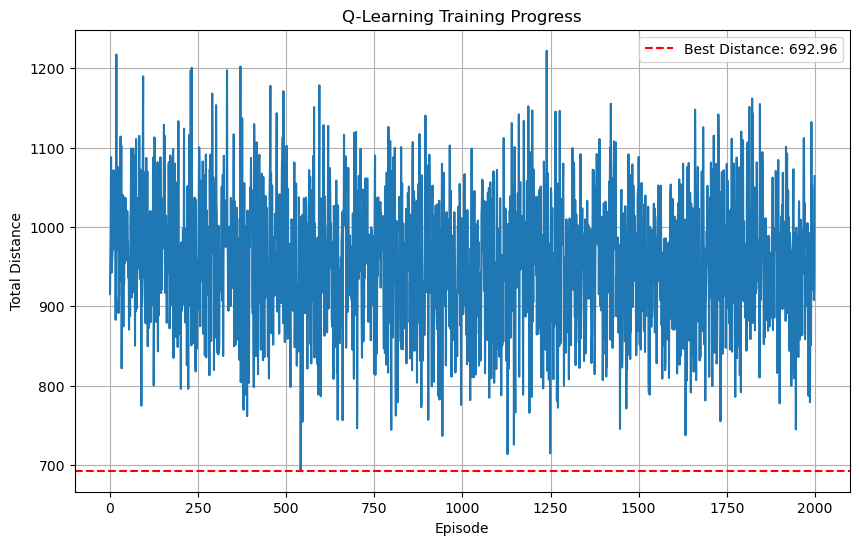

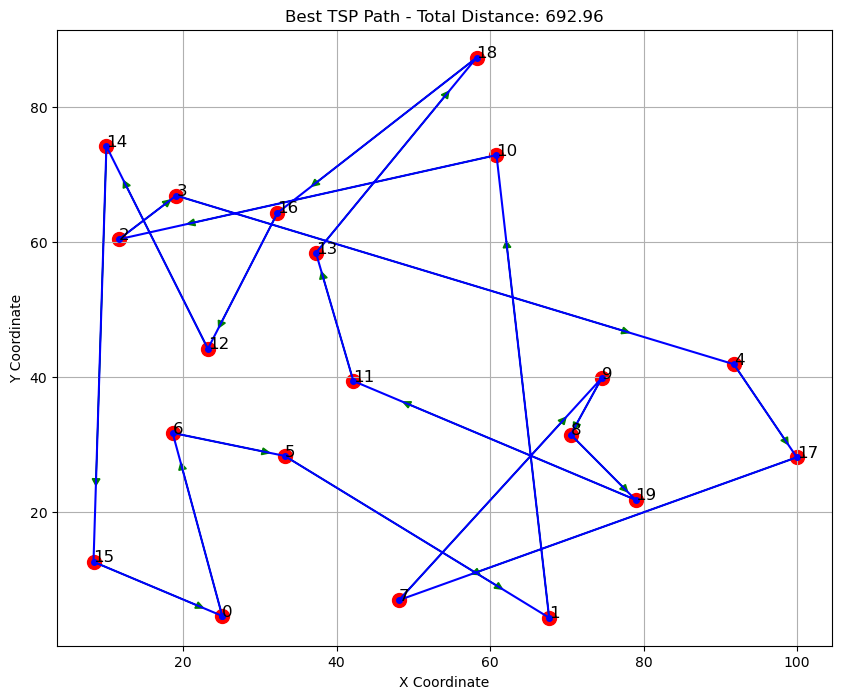

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance_matrix

class QLearningTSP:
    def __init__(self, cities, learning_rate=0.1, discount_factor=0.95, 
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration=0.01):
        """
        初始化Q-Learning TSP求解器
        
        参数:
        cities - 城市坐标列表，格式为[(x1, y1), (x2, y2), ...]
        learning_rate - 学习率 (alpha)
        discount_factor - 折扣因子 (gamma)
        exploration_rate - 初始探索率 (epsilon)
        exploration_decay - 探索率衰减因子
        min_exploration - 最小探索率
        """
        self.cities = np.array(cities)
        self.n_cities = len(cities)
        
        # 计算城市间距离矩阵
        self.distances = distance_matrix(self.cities, self.cities)
        
        # 强化学习参数
        self.learning_rate = learning_rate #学习率α，控制新信息覆盖旧信息的程度
        self.discount_factor = discount_factor #折扣因子γ，平衡即时奖励和未来奖励
        self.exploration_rate = exploration_rate #初始探索率ε
        self.exploration_decay = exploration_decay #探索率衰减因子
        self.min_exploration = min_exploration #最小探索率
        
        # 初始化Q表
        # Q表维度: [当前城市, 已访问城市集合] -> 动作(下一个城市)的价值
        # 使用字典存储Q值，因为状态空间很大
        self.q_table = {}
        
        # 记录训练过程中的最佳路径和距离
        self.best_path = None
        self.best_distance = float('inf')
        self.history = []
    
    def state_to_key(self, current_city, visited):
        """
        将状态转换为字典键
        current_city: 当前所在城市索引
        visited: 已访问城市集合的元组（按城市索引排序）
        """
        # 将集合转换为排序后的元组，使其可哈希
        return (current_city, tuple(sorted(visited)))
    
    def get_q_value(self, state_key, action):
        """
        获取Q值，如果状态-动作对不存在则初始化为0
        """
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_cities)
        return self.q_table[state_key][action]
    
    def set_q_value(self, state_key, action, value):
        """
        设置Q值
        """
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_cities)
        self.q_table[state_key][action] = value
    
    def get_valid_actions(self, current_city, visited):
        """
        获取当前状态下的有效动作（未访问的城市）
        """
        # 所有城市索引
        all_cities = set(range(self.n_cities))
        # 未访问的城市
        unvisited = list(all_cities - visited)
        
        # 如果所有城市都已访问，则返回起始城市（完成回路）
        if len(unvisited) == 0:
            return [0]  # 假设起始城市索引为0
        
        return unvisited
    
    def choose_action(self, current_city, visited):
        """
        使用ε-贪婪策略选择动作
        """
        # ε-贪婪策略：以ε的概率进行探索，否则进行利用
        if np.random.rand() < self.exploration_rate:
            # 探索：随机选择一个有效动作
            valid_actions = self.get_valid_actions(current_city, visited)
            return random.choice(valid_actions)
        else:
            # 利用：选择Q值最大的动作
            state_key = self.state_to_key(current_city, visited)
            q_values = self.q_table.get(state_key, np.zeros(self.n_cities))
            
            # 只考虑有效动作
            valid_actions = self.get_valid_actions(current_city, visited)
            # 如果没有有效动作，返回起始城市
            if not valid_actions:
                return 0
            
            # 在有效动作中选择Q值最大的
            max_q = -float('inf')
            best_action = None
            for action in valid_actions:
                if q_values[action] > max_q:
                    max_q = q_values[action]
                    best_action = action
            
            return best_action
    
    def calculate_path_distance(self, path):
        """
        计算给定路径的总距离
        """
        total_distance = 0
        for i in range(len(path)):
            from_city = path[i]
            to_city = path[(i + 1) % len(path)]  # 循环回起点
            total_distance += self.distances[from_city][to_city]
        return total_distance
    
    def train(self, episodes=1000):
        """
        训练Q-Learning模型
        
        参数:
        episodes - 训练轮次
        """
        for episode in range(episodes):
            # 初始化状态：从起始城市开始（索引0），已访问集合包含起始城市
            current_city = 0
            visited = {0}
            path = [0]  # 记录路径
            
            # 完成一个完整的旅行
            while len(visited) < self.n_cities:
                # 选择动作（下一个城市）
                action = self.choose_action(current_city, visited)
                
                # 执行动作：移动到下一个城市
                next_city = action
                
                # 计算奖励：负的距离（因为我们希望最小化距离）
                reward = -self.distances[current_city][next_city]
                
                # 更新状态
                new_visited = visited | {next_city}
                
                # 获取当前状态的Q值
                state_key = self.state_to_key(current_city, visited)
                current_q = self.get_q_value(state_key, action)
                
                # 寻找下一个状态的最大Q值
                next_state_key = self.state_to_key(next_city, new_visited)
                next_max_q = -float('inf')
                
                # 如果还有未访问的城市
                if len(new_visited) < self.n_cities:
                    valid_actions = self.get_valid_actions(next_city, new_visited)
                    for a in valid_actions:
                        q_val = self.get_q_value(next_state_key, a)
                        if q_val > next_max_q:
                            next_max_q = q_val
                else:
                    # 所有城市已访问，下一步是返回起点
                    next_max_q = self.get_q_value(next_state_key, 0)
                
                # 计算目标Q值
                target_q = reward + self.discount_factor * next_max_q
                
                # 更新Q值
                new_q = current_q + self.learning_rate * (target_q - current_q)
                self.set_q_value(state_key, action, new_q)
                
                # 更新当前状态
                current_city = next_city
                visited = new_visited
                path.append(current_city)
            
            # 计算并记录路径距离
            total_distance = self.calculate_path_distance(path)
            self.history.append(total_distance)
            
            # 更新最佳路径
            if total_distance < self.best_distance:
                self.best_distance = total_distance
                self.best_path = path.copy()
            
            # 衰减探索率
            self.exploration_rate = max(self.min_exploration, 
                                       self.exploration_rate * self.exploration_decay)
            
            # 每100轮打印一次进度
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode+1}/{episodes} - "
                      f"Best Distance: {self.best_distance:.2f} - "
                      f"Exploration Rate: {self.exploration_rate:.4f}")
    
    def plot_learning_curve(self):
        """绘制学习曲线"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.history)
        plt.title("Q-Learning Training Progress")
        plt.xlabel("Episode")
        plt.ylabel("Total Distance")
        plt.grid(True)
        
        # 添加最佳距离线
        if self.best_distance < float('inf'):
            plt.axhline(y=self.best_distance, color='r', linestyle='--', 
                        label=f"Best Distance: {self.best_distance:.2f}")
            plt.legend()
        
        plt.show()
    
    def plot_best_path(self):
        """绘制最佳路径"""
        if self.best_path is None:
            print("No best path available. Train the model first.")
            return
        
        plt.figure(figsize=(10, 8))
        cities = self.cities
        
        # 绘制城市点
        plt.scatter(cities[:, 0], cities[:, 1], c='red', s=100)
        
        # 标记城市编号
        for i, city in enumerate(cities):
            plt.text(city[0], city[1], str(i), fontsize=12)
        
        # 绘制路径
        path = np.array([cities[i] for i in self.best_path])
        path = np.vstack([path, cities[0]])  # 回到起点
        
        plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=1.5)
        plt.plot(path[:, 0], path[:, 1], 'bo', markersize=4)
        
        # 添加箭头表示方向
        for i in range(len(path)-1):
            dx = path[i+1, 0] - path[i, 0]
            dy = path[i+1, 1] - path[i, 1]
            plt.arrow(path[i, 0], path[i, 1], dx*0.8, dy*0.8, 
                      head_width=1, head_length=1, fc='green', ec='green')
        
        plt.title(f"Best TSP Path - Total Distance: {self.best_distance:.2f}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.grid(True)
        plt.show()


# ===================== 示例用法 =====================

if __name__ == "__main__":
    # 随机生成城市的坐标
    np.random.seed(41)
    n_cities = 20
    cities = np.random.rand(n_cities, 2) * 100
    
    # 创建QLearningTSP实例
    tsp_solver = QLearningTSP(
        cities,
        learning_rate=0.1,
        discount_factor=0.95,
        exploration_rate=1.0,
        exploration_decay=0.999,
        min_exploration=0.01
    )
    
    # 训练模型
    print("Starting training...")
    tsp_solver.train(episodes=2000)
    
    # 输出结果
    print("\nTraining completed!")
    print(f"Best path: {tsp_solver.best_path}")
    print(f"Best distance: {tsp_solver.best_distance:.2f}")
    
    # 绘制学习曲线和最佳路径
    tsp_solver.plot_learning_curve()
    tsp_solver.plot_best_path()